In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Dataseti import edilmesi
df = pd.read_csv("turkey_earthquakes(1915-2021).csv", sep=";", encoding="latin1")
# Datasetin görünümü
print(df.columns.tolist())
print(df.head(10))
print(df.dtypes)

# Sadece gerekli sütünlar
df = df[['Olus tarihi', 'Olus zamani', 'Enlem', 'Boylam', 'Derinlik', 'Mw']]

# Mw (Moment Magnitude) olmayan satırları çıkarma
df = df.dropna(subset=['Mw'])

['No', 'Deprem Kodu', 'Olus tarihi', 'Olus zamani', 'Enlem', 'Boylam', 'Derinlik', 'xM', 'MD', 'ML', 'Mw', 'Ms', 'Mb', 'Tip', 'Yer']
   No   Deprem Kodu Olus tarihi  Olus zamani    Enlem   Boylam  Derinlik   xM  \
0   1  2.021010e+13  2021.01.01  16:36:21.41  35.9273  27.8658      26.1  3.9   
1   2  2.020120e+13  2020.12.31  00:51:27.94  37.8435  26.7775       8.0  3.8   
2   3  2.020120e+13  2020.12.30  18:45:12.79  36.4918  28.7092       5.0  3.9   
3   4  2.020120e+13  2020.12.30  13:40:12.22  37.7960  26.4165      14.4  4.4   
4   5  2.020120e+13  2020.12.27  20:08:36.88  38.4172  39.1482       5.0  3.9   
5   6  2.020120e+13  2020.12.27  07:13:55.51  36.4750  28.7852       2.8  4.2   
6   7  2.020120e+13  2020.12.27  06:37:31.16  38.5050  39.2180       2.9  5.6   
7   8  2.020120e+13  2020.12.26  11:09:18.51  38.5305  39.2102       5.0  4.1   
8   9  2.020120e+13  2020.12.26  09:31:18.20  38.0033  42.9642       5.0  3.9   
9  10  2.020120e+13  2020.12.23  21:13:42.34  36.5213  28

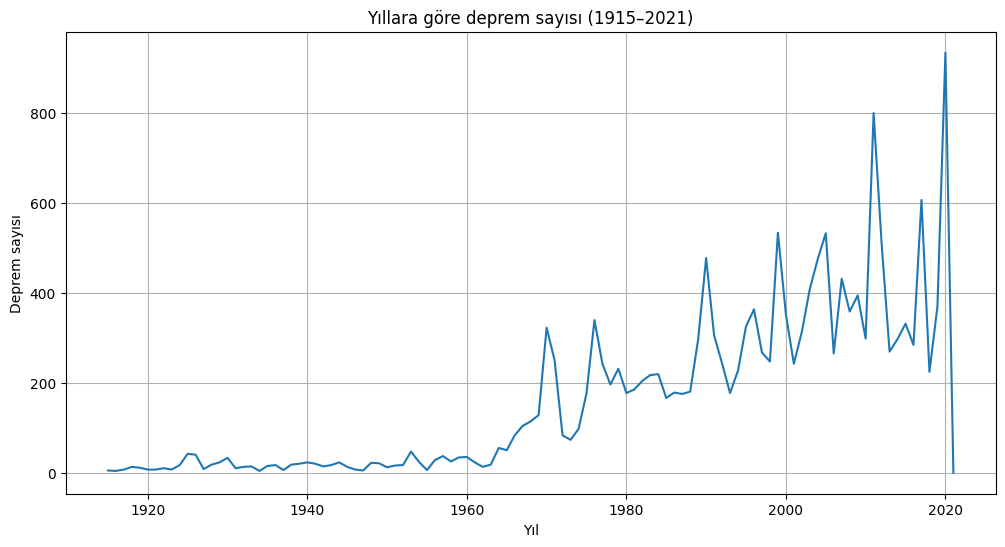

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Dataseti import etme
df = pd.read_csv("turkey_earthquakes(1915-2021).csv", sep=";", encoding="latin1")

df["Olus tarihi"] = (
    df["Olus tarihi"]
    .astype(str)                         # 2021.01.01 → "2021.01.01"
    .str.replace(".", "-", regex=False)   # "2021.01.01" → "2021-01-01"
)

df["Olus tarihi"] = pd.to_datetime(df["Olus tarihi"], errors="coerce")

# Tanınmayan tarihlerin kaldırılması
df = df.dropna(subset=["Olus tarihi"])

# Yılları alıyoruz
df["Yil"] = df["Olus tarihi"].dt.year.astype(int)

# Depremlerin sayısını yıllara göre sayıyoruz
year_counts = df["Yil"].value_counts().sort_index()

# Grafik
plt.figure(figsize=(12, 6))
plt.plot(year_counts.index, year_counts.values)

plt.xlabel("Yıl")
plt.ylabel("Deprem sayısı")
plt.title("Yıllara göre deprem sayısı (1915–2021)")
plt.grid(True)
plt.show()


In [20]:
# Tarih formatını düzelt
df['Olus tarihi'] = df['Olus tarihi'].astype(str).str.replace(".", "-", regex=False)
df['Olus tarihi'] = pd.to_datetime(df['Olus tarihi'], errors='coerce')

# Zaman formatını düzeltme: milisaniyeyi silme
df['Olus zamani'] = df['Olus zamani'].astype(str).str.split('.').str[0]

# Zamani saniyeye cevir
def time_to_seconds(t):
    try:
        h, m, s = map(int, t.split(':'))
        return h*3600 + m*60 + s
    except:
        return np.nan

df['Olus zamani'] = df['Olus zamani'].apply(time_to_seconds)

# gerekli kolonlar
df = df[['Olus tarihi', 'Olus zamani', 'Enlem', 'Boylam', 'Derinlik', 'Mw']]

# Tarihi integer yapmak
df['Olus tarihi'] = df['Olus tarihi'].map(pd.Timestamp.toordinal)

# NaN varsa sil
df = df.dropna()

In [21]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [38]:
def create_sequences(data, window=20):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i, 5])  # Mw sutunu 5 indexe kadar ekleme
    return np.array(X), np.array(y)

window_size = 20
X, y = create_sequences(scaled_data, window_size)

# Train-test ayrımı
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [39]:
class EarthquakeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(EarthquakeDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader  = DataLoader(EarthquakeDataset(X_test,  y_test), batch_size=32, shuffle=False)

In [40]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   # son zaman adımı
        out = self.relu(self.fc1(out))
        return self.fc2(out)

model = LSTMModel(input_size=X_train.shape[2]).to(DEVICE)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [41]:
EPOCHS = 30
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        preds = model(X_batch).squeeze()
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validasyon
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            preds = model(X_batch.to(DEVICE)).squeeze()
            loss = criterion(preds.cpu(), y_batch)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")



Epoch 1/30 - Train Loss: 0.0312 - Val Loss: 0.0036
Epoch 2/30 - Train Loss: 0.0138 - Val Loss: 0.0035
Epoch 3/30 - Train Loss: 0.0132 - Val Loss: 0.0057
Epoch 4/30 - Train Loss: 0.0130 - Val Loss: 0.0072
Epoch 5/30 - Train Loss: 0.0128 - Val Loss: 0.0044
Epoch 6/30 - Train Loss: 0.0126 - Val Loss: 0.0051
Epoch 7/30 - Train Loss: 0.0126 - Val Loss: 0.0054
Epoch 8/30 - Train Loss: 0.0128 - Val Loss: 0.0037
Epoch 9/30 - Train Loss: 0.0124 - Val Loss: 0.0036
Epoch 10/30 - Train Loss: 0.0125 - Val Loss: 0.0036
Epoch 11/30 - Train Loss: 0.0125 - Val Loss: 0.0039
Epoch 12/30 - Train Loss: 0.0123 - Val Loss: 0.0036
Epoch 13/30 - Train Loss: 0.0125 - Val Loss: 0.0034
Epoch 14/30 - Train Loss: 0.0122 - Val Loss: 0.0033
Epoch 15/30 - Train Loss: 0.0122 - Val Loss: 0.0059
Epoch 16/30 - Train Loss: 0.0124 - Val Loss: 0.0034
Epoch 17/30 - Train Loss: 0.0123 - Val Loss: 0.0085
Epoch 18/30 - Train Loss: 0.0124 - Val Loss: 0.0051
Epoch 19/30 - Train Loss: 0.0125 - Val Loss: 0.0033
Epoch 20/30 - Train L

In [42]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds = model(X_batch.to(DEVICE)).cpu().numpy().flatten()
        all_preds.extend(preds)
        all_targets.extend(y_batch.numpy().flatten())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

mae  = mean_absolute_error(all_targets, all_preds)
mse  = mean_squared_error(all_targets, all_preds)
rmse = np.sqrt(mse)
r2   = r2_score(all_targets, all_preds)

print("\n------ METRICS ------")
print("MAE :", mae)
print("MSE :", mse)
print("RMSE:", rmse)
print("R²  :", r2)


------ METRICS ------
MAE : 0.04659975692629814
MSE : 0.004160610027611256
RMSE: 0.06450279085133646
R²  : -0.11936736106872559


In [43]:
print("\nGerçek :", all_targets[:5])
print("Tahmin :", all_preds[:5])


Gerçek : [0.5584416  0.6103896  0.72727275 0.6233766  0.6363636 ]
Tahmin : [0.6243976  0.61697465 0.6146105  0.6215929  0.621636  ]


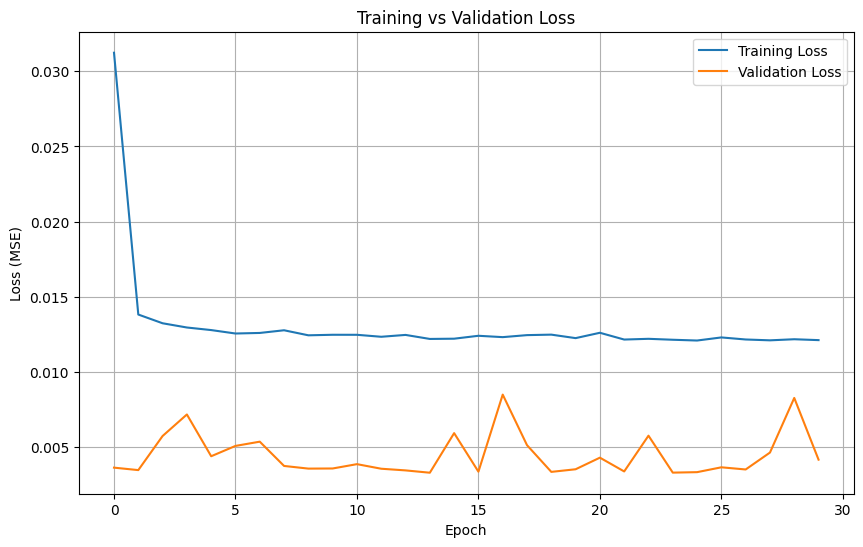

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses,   label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()
plt.show()